### HandPD Meander

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
from fastai.vision import *
from fastai.metrics import accuracy
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/gdrive


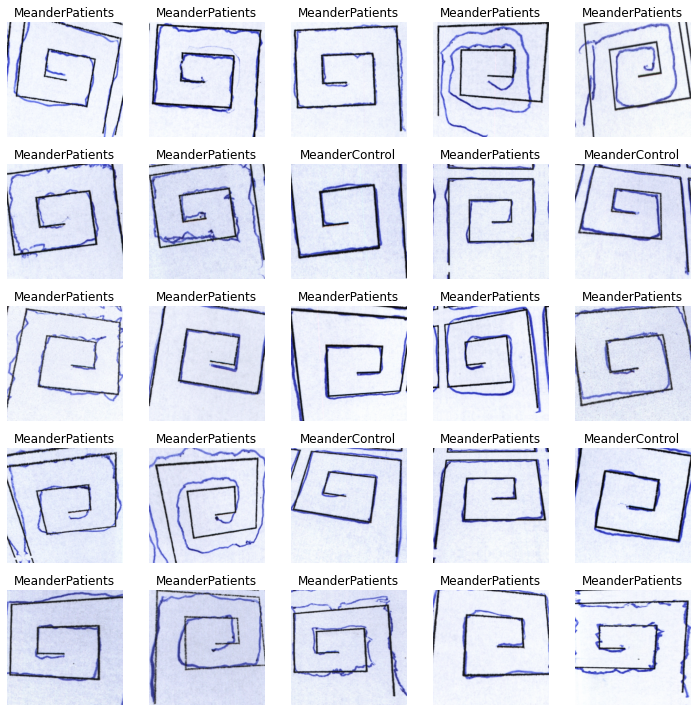

In [2]:
np.random.seed(42)
data = ImageDataBunch.from_folder(Path("/content/gdrive/My Drive/" + "HandPD/Meander_HandPD"), train='.', 
                                  ds_tfms=get_transforms(), valid_pct=0.2, size=(224,224), num_workers=4).normalize(imagenet_stats)
data.show_batch(rows=5, figsize=(10, 10))

#### VGG16

In [3]:
learn = cnn_learner(data, models.vgg16_bn, metrics =accuracy)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [4]:
learn.fit_one_cycle(4)

In [5]:
learn.save('vgg16_one')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


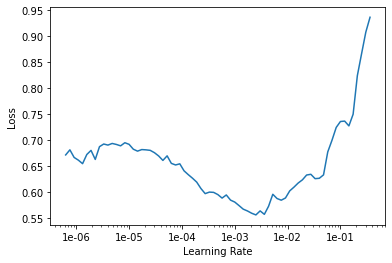

In [6]:
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

In [8]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-3))

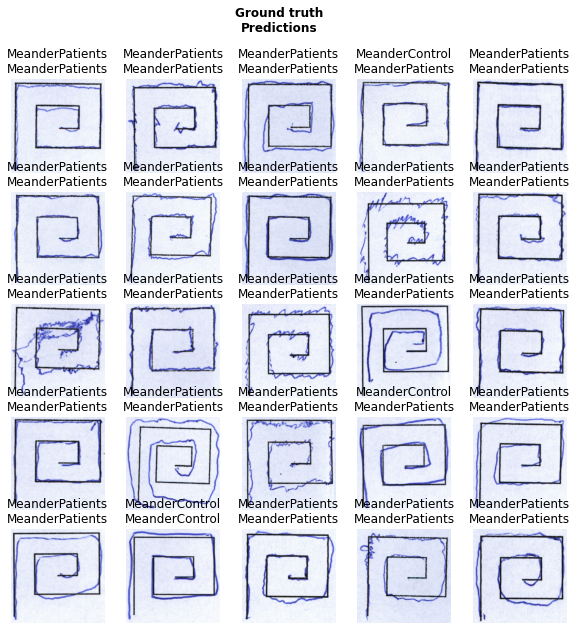

In [9]:
learn.save('vgg16_two')
learn.show_results(rows=5, figsize=(10,10))

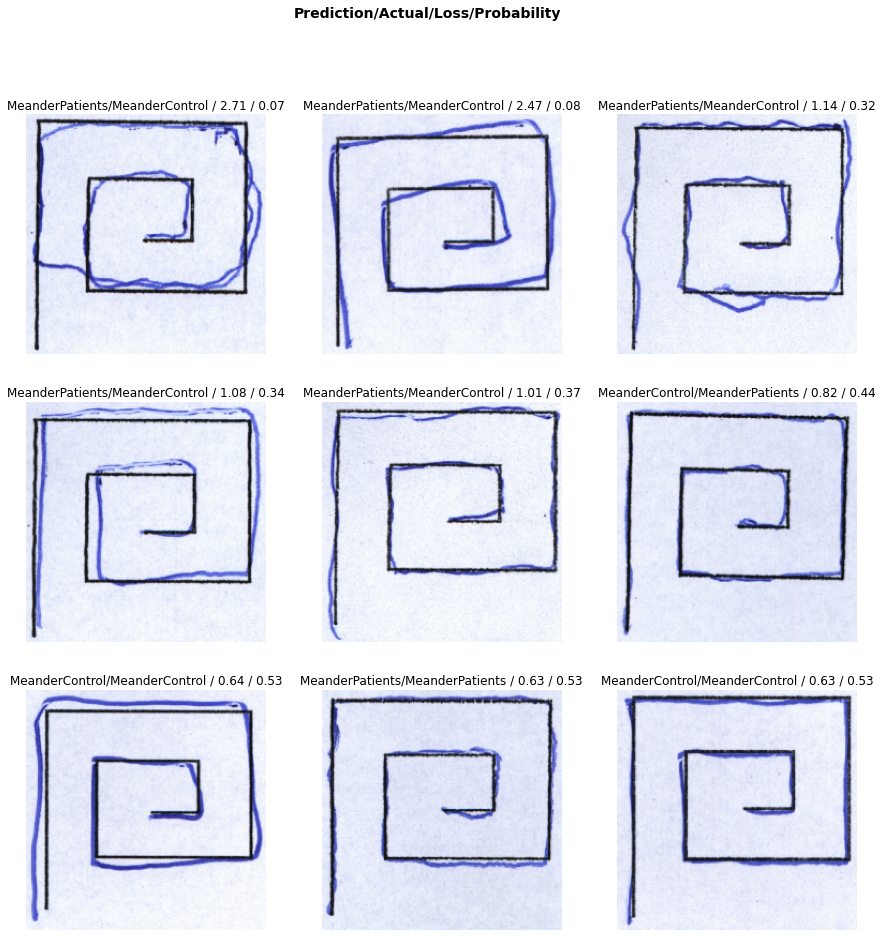

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))

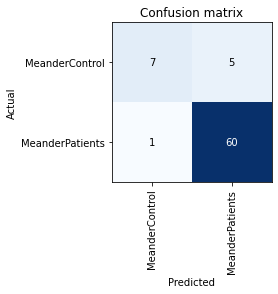

In [11]:
interp.plot_confusion_matrix()

#### VGG19

In [12]:
learn = cnn_learner(data, models.vgg19_bn, metrics =accuracy)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [13]:
learn.fit_one_cycle(4)

In [14]:
learn.save('vgg19_one')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


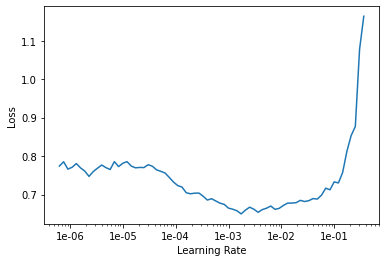

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

In [17]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

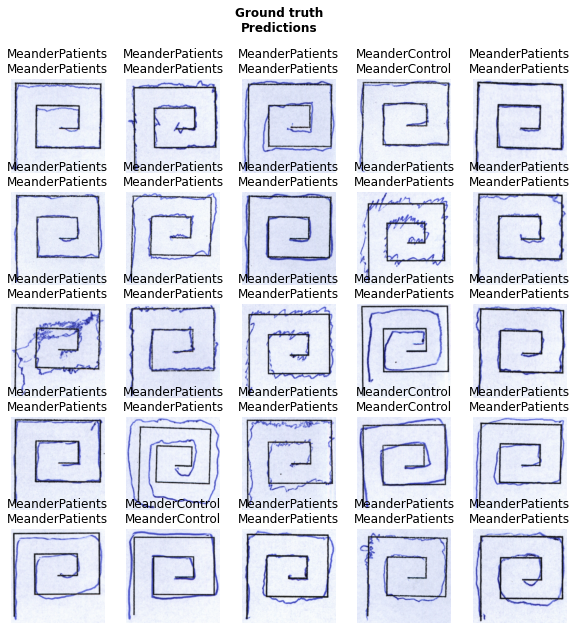

In [18]:
learn.save('vgg19_two')
learn.show_results(rows=5, figsize=(10,10))

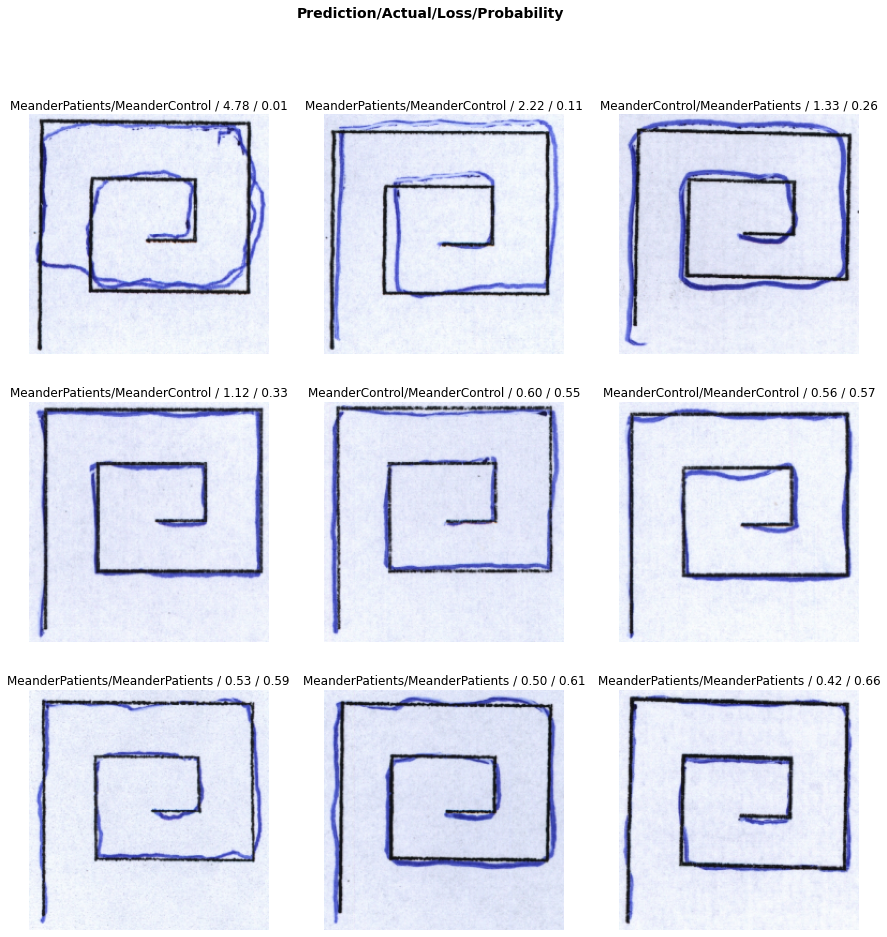

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))

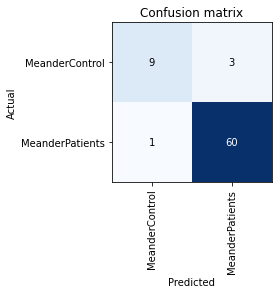

In [20]:
interp.plot_confusion_matrix()

#### RESNET50

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [22]:
learn.fit_one_cycle(4)

In [23]:
learn.save('resnet50_one')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


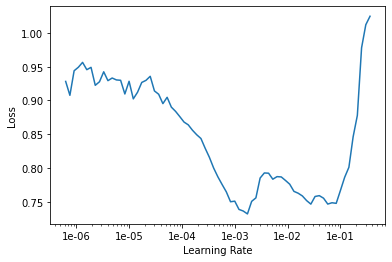

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

In [26]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

In [29]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

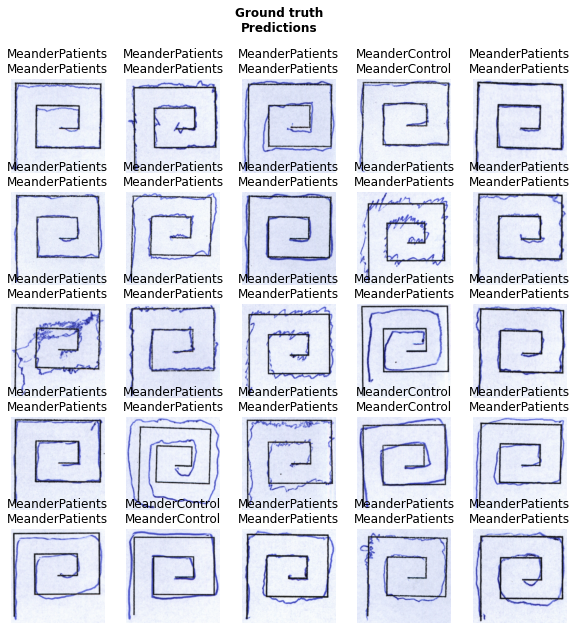

In [30]:
learn.save('resnet50_two')
learn.show_results(rows=5, figsize=(10,10))

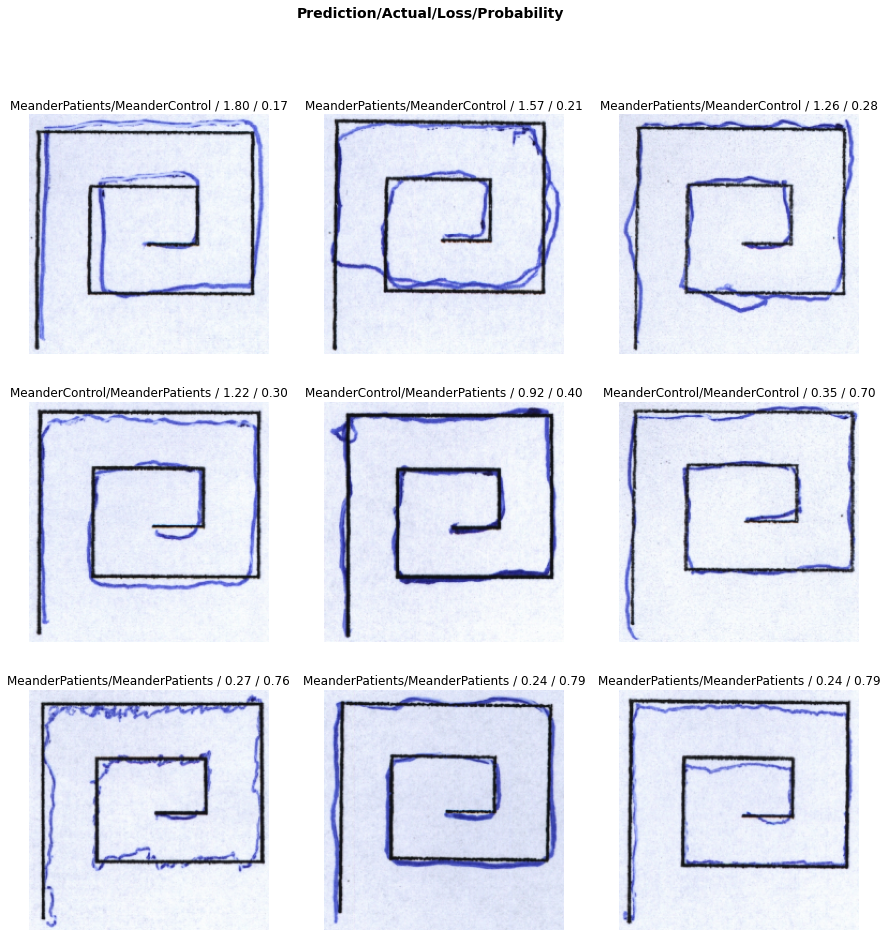

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))

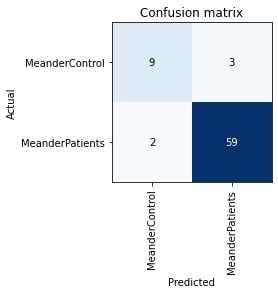

In [32]:
interp.plot_confusion_matrix()

#### RESNET101

In [42]:
learn = cnn_learner(data, models.resnet101, metrics=accuracy)

In [43]:
learn.fit_one_cycle(4)

In [44]:
learn.save('resnet101_one')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


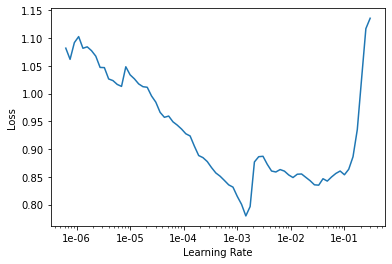

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

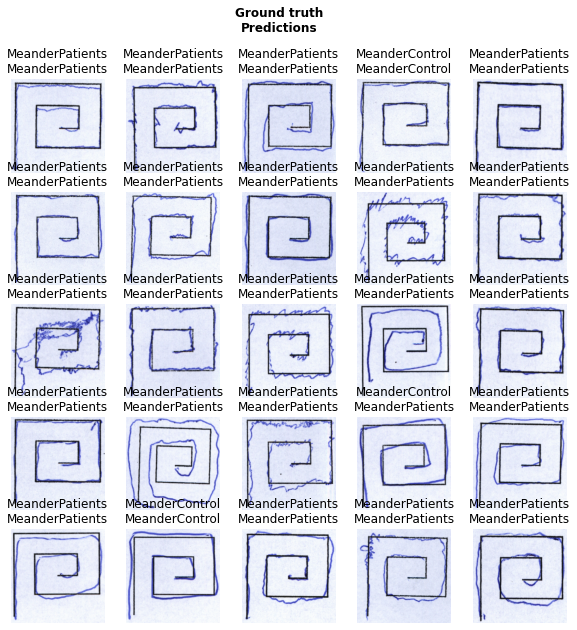

In [47]:
learn.save('resnet101_two')
learn.show_results(rows=5, figsize=(10,10))

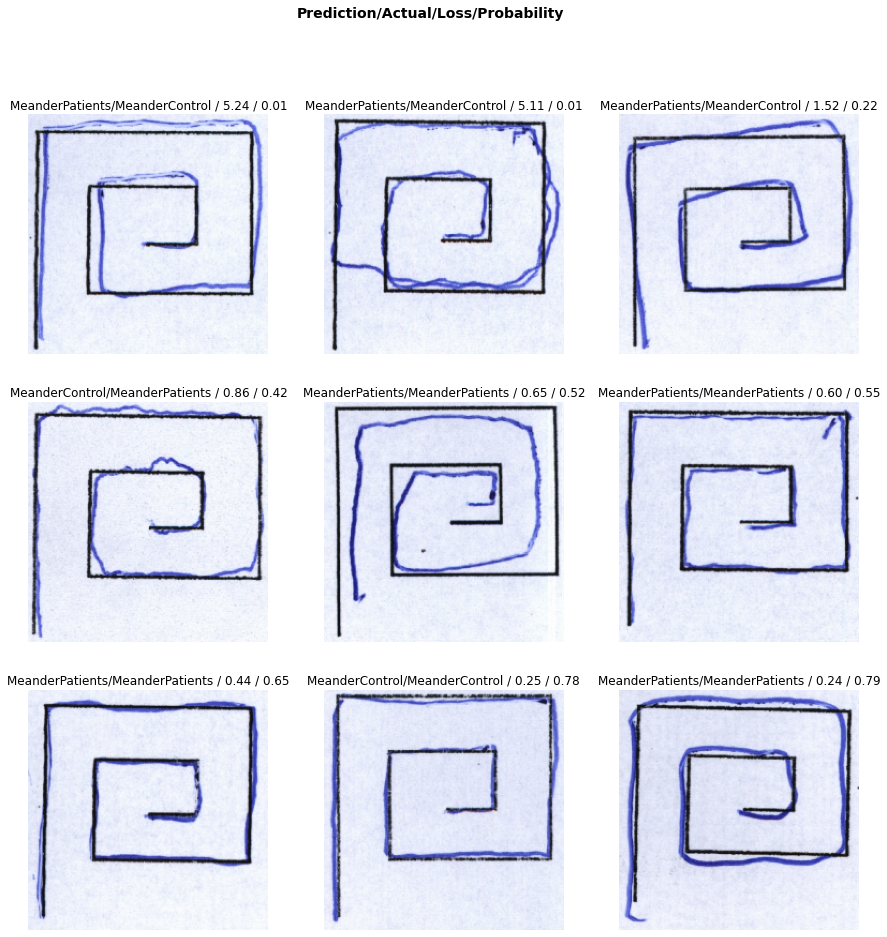

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))

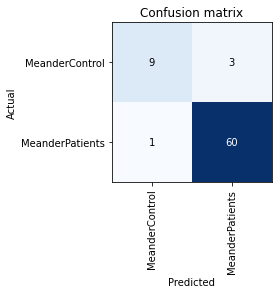

In [49]:
interp.plot_confusion_matrix()

#### Ансамбль

In [50]:
learn = cnn_learner(data, models.vgg16_bn, metrics =accuracy)
learn_vgg16 = learn.load('vgg16_two')

In [51]:
learn = cnn_learner(data, models.vgg19_bn, metrics =accuracy)
learn_vgg19 = learn.load('vgg19_two')

In [52]:
learn = cnn_learner(data, models.resnet50, metrics =accuracy)
learn_resnet50 = learn.load('resnet50_two')

In [53]:
learn = cnn_learner(data, models.resnet101, metrics =accuracy)
learn_resnet101 = learn.load('resnet101_two')

In [54]:
pred_vgg16,target_vgg16 = learn_vgg16.get_preds(data)
pred_vgg19, target_vgg19 = learn_vgg19.get_preds(data)
pred_resnet50, target_resnet50 = learn_resnet50.get_preds(data)
pred_resnet101, target_resnet101 = learn_resnet101.get_preds(data)

In [55]:
final_preds = 0.25 * pred_vgg16 + 0.25 * pred_vgg19 + 0.25 * pred_resnet50 + 0.25 * pred_resnet101

In [56]:
count = 0
tp, tn, fp, fn = 0, 0, 0, 0
for i in range(len(final_preds)):
  if final_preds.numpy()[i][0] > final_preds.numpy()[i][1]:
    if target_vgg16.numpy()[i] == 0:
      tn += 1
    else:
      fp +=1
  if final_preds.numpy()[i][0] < final_preds.numpy()[i][1]:
    if target_vgg16.numpy()[i] == 0:
      fn += 1
    else:
      tp +=1
print((tp+tn)/len(final_preds),"\n", tp/(tp+fn),"\n", tn/(tn+fp))
print(tp, fn, "\n", fp, tn)
#  if final_preds.numpy()[i][target_vgg16.numpy()[i]] > final_preds.numpy()[i][int(not(target_vgg16.numpy()[i]))]:
#    count = count + 1
#print(count/len(final_preds))

0.9593220338983051 
 0.9704641350210971 
 0.9137931034482759
230 7 
 5 53


Предсказание на загруженных изображениях

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()

Saving 2.jpg to 2 (1).jpg


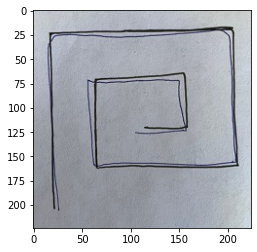

In [ ]:
img = Image.open(BytesIO(uploaded['2.jpg']))
plt.imshow(img)